ENERGY BALANCE ANALYSIS & PREDICTION

BUSINESS UNDERSTANDING

The EU aims to be climate-neutral by 2050.
>I found a dataset with energy source balance on Kaggle (data ranging from 1990 to 2019): https://www.kaggle.com/gpreda/energy-balance-in-europe

The data contains 3 files:

> energy consumption and production balance in Europe between 1991 and 2019, per country, energy balance code, energy production source, unit, and geography: energy_balance_eu.csv;

> Energy balance dictionary of terms - nrg_bal_dict.csv;

> Energy production sources dictionary of terms - siec_dict.csv; (not required for the purposes of this exercise)


These are the questions that's I'd like to answer:
> 1. Can we group the energy sources by their climate impact?
> 2. Can we observe a trend on the historic data in each of the identified groups?
> 3. Can we predict trend of energy consumption in each of the groups until 2050?
> 4. How does the prediction correspond to the goal of climate neutrality in 2050?

DATA UNDERSTANDING

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import seaborn as sns
%matplotlib inline
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

df = pd.read_csv('/Users/AlinaV/Udacity/energy/data/energy_balance_eu.csv')
df.head()

,nrg_bal,siec,unit,geo,TIME_PERIOD,OBS_VALUE
0,AFC,C0000X0350-0370,GWH,AL,1990,6644.088
1,AFC,C0000X0350-0370,GWH,AL,1991,3816.945
2,AFC,C0000X0350-0370,GWH,AL,1992,1067.475
3,AFC,C0000X0350-0370,GWH,AL,1993,525.540
4,AFC,C0000X0350-0370,GWH,AL,1994,459.514


In the file we have a certain distribution of data among years. Let's see how many data points we have per year.

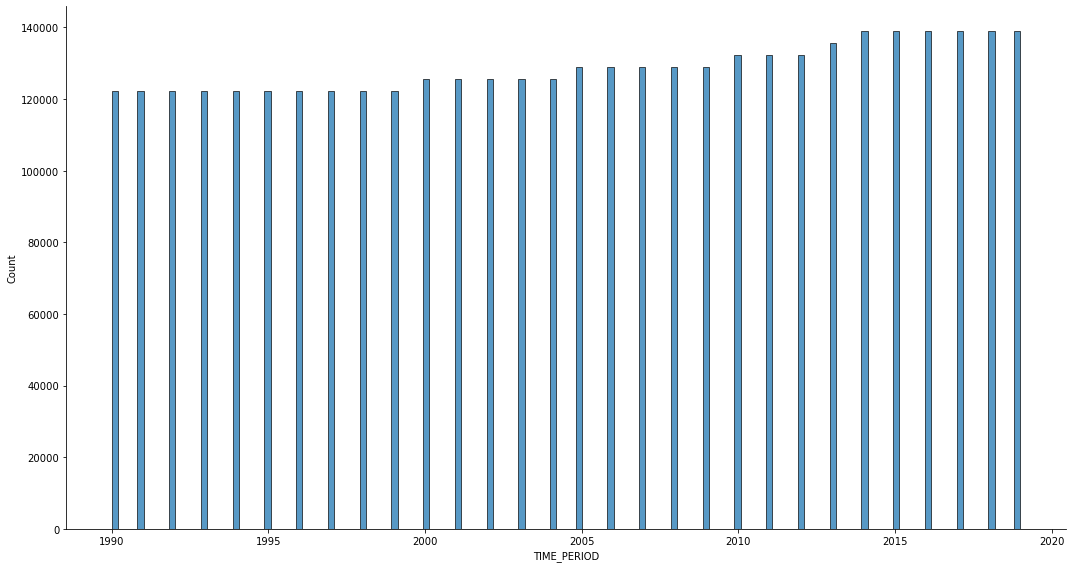

In [2]:
displot_year = sns.displot(df, x="TIME_PERIOD", height=8, aspect=15/8)
plt.show()

The distribution looks quite fair, we have approximately the same number of datapoints for each year. Roughly the same observation applies to geography, there are some patches where we have less geographical representation, but the variability is not high.

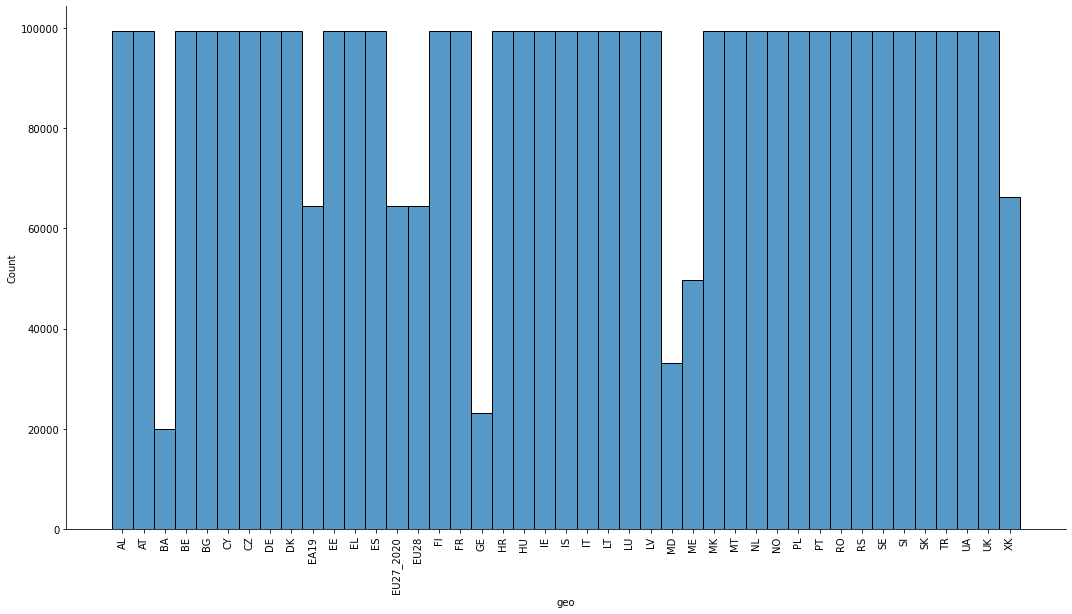

In [3]:
displot_geo = sns.displot(df, x="geo", height=8, aspect=15/8)
plt.xticks(rotation=90)
plt.show()

DATA PREPARATION

The "obs_value" column can only be interpreted with the help of "unit", and it looks like different units are used.

In [4]:
df.unit.value_counts()

TJ      1287672
GWH     1287672
KTOE    1287672
Name: unit, dtype: int64

The count of values for each unit is suspiciously the same, it seems that we have the entire dataset duplicated twice with different unit formulas. Let's split our last graph by unit.

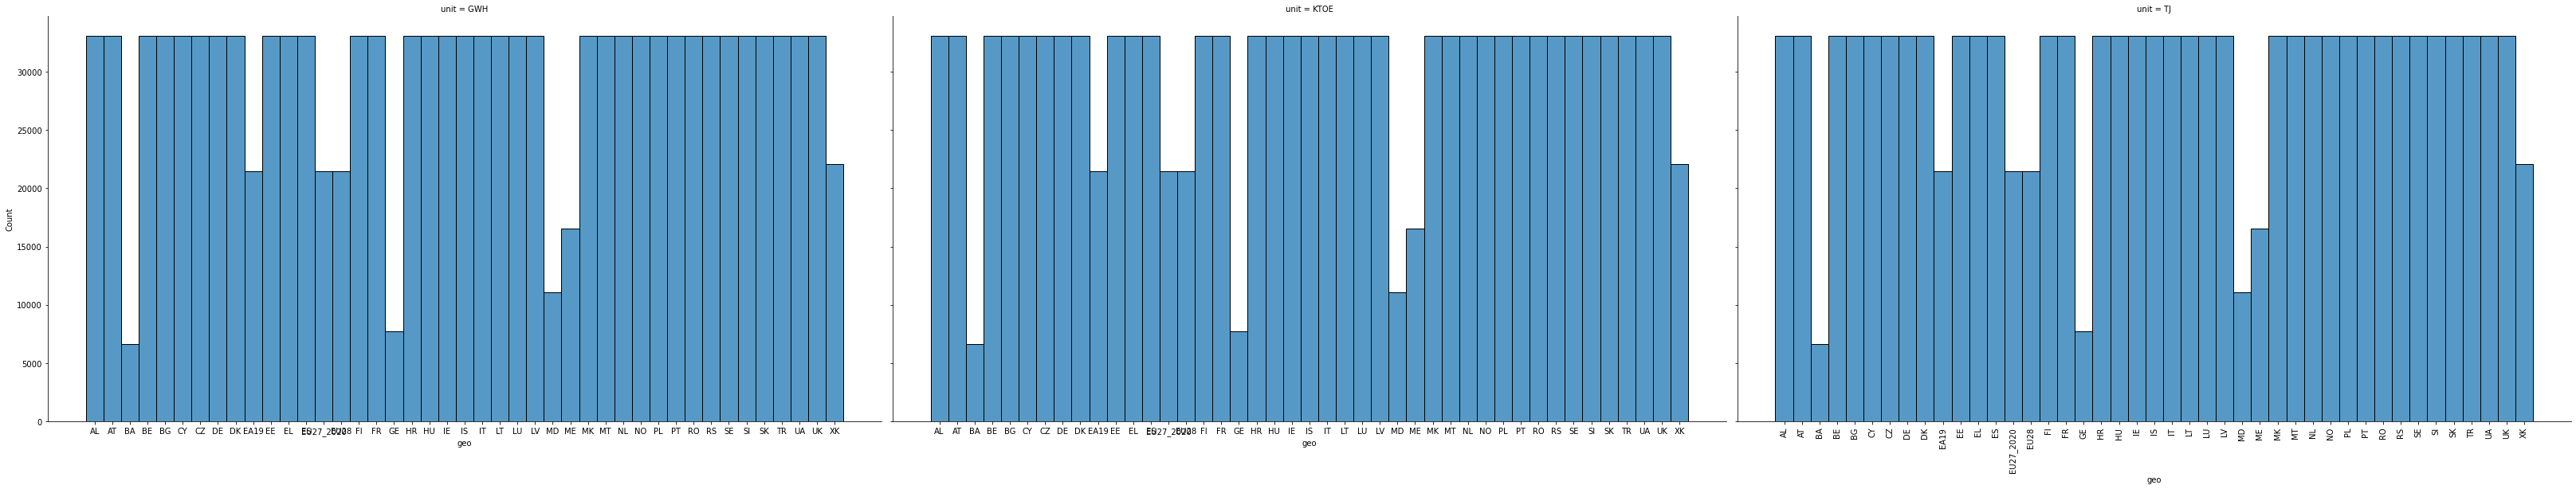

In [5]:
displot_geo_unit = sns.displot(df, x="geo", col="unit", height=8, aspect=15/8)
plt.xticks(rotation=90)
plt.show()

In [6]:
(np.sum(df.isnull())/df.shape[0])*100 # let's also check % missing values here

nrg_bal         0.000000
siec            0.000000
unit            0.000000
geo             0.000000
TIME_PERIOD     0.000000
OBS_VALUE      33.386142
dtype: float64

Yes, it's identical. So in fact, our dataset is three times shorter and we can select a unit of choosing.  I'll choose GWH (Gigawatt hours) and will filter the dataset to that. And I will double check missing values to make sure the datasets by unit were not complementary.

In [7]:
df_gwh = df[df["unit"] == "GWH"]

In [8]:
(np.sum(df_gwh.isnull())/df_gwh.shape[0])*100 

nrg_bal         0.000000
siec            0.000000
unit            0.000000
geo             0.000000
TIME_PERIOD     0.000000
OBS_VALUE      33.386142
dtype: float64

Now let's check if we have any duplicates and missing data.

In [9]:
df_gwh['duplicate'] = df_gwh.duplicated(subset=None, keep='first')
df_gwh.duplicate.value_counts()

False    1287672
Name: duplicate, dtype: int64

There are no duplicates, but there were some missing values as we learned above (33% observed values are missing), which make further analysis of these rows pointless. I will remove them.

In [10]:
df_gwh = df_gwh.drop(columns=['duplicate'])
df_gwh = df_gwh.dropna(subset=['OBS_VALUE'], axis=0)

In [11]:
(np.sum(df_gwh.isnull())/df_gwh.shape[0])*100

nrg_bal        0.0
siec           0.0
unit           0.0
geo            0.0
TIME_PERIOD    0.0
OBS_VALUE      0.0
dtype: float64

In [12]:
df_gwh.select_dtypes(include=['object']).nunique() #  check unique values in each column

nrg_bal    92
siec       12
unit        1
geo        43
dtype: int64

We need to see how the usage of energy sources and the energy balance changed over years, so let's look at the first two columns. First of all I am interested in understanding which energy sources are climate-friendly and which aren't. 

In [13]:
df_source = pd.read_csv('/Users/AlinaV/Udacity/energy/data/siec_dict.csv')
df_source.head(50)

,siec,siec_name
0,TOTAL,Total
1,CF,Combustible fuels
2,CF_R,Combustible fuels - renewable
3,CF_NR,Combustible fuels - non-renewable
4,CF_NR_OTH,Combustible fuels - non-renewable - other
5,FF,Fossil fuels
6,SFF_P1000,Solid fossil fuels and peat
7,SFF_P1000_S2000,"Solid fossil fuels, peat, peat products, oil s..."
8,C0000,Coal and manufactured gases
9,C0000X0350-0370,Solid fossil fuels


In [14]:
df_source.shape[0]

235

What can be observed is that some categories give a "total", e.g. "Natural gas" and some give subtotals "Compressed natural gas" and "Liquefied natural gas". We can't run a comparison on nested granularity, so let's look at the most popular categories of sources in our data and define the area of focus. There are only 12 out of 235 in the dictionary. Let's also convert our GWH into TWH (divide by 1000).

In [15]:
df_twh = df_gwh
df_twh['OBS_VALUE'] = (df['OBS_VALUE'] / 1000).round(0)

In [16]:
df_twh.groupby(['siec']).sum().sort_values('OBS_VALUE', ascending=False)

,TIME_PERIOD,OBS_VALUE
siec,,
TOTAL,220970752,29840471.0
O4000XBIO,160924352,11067968.0
G3000,141709504,3893432.0
C0000X0350-0370,160924352,2902551.0
E7000,134503936,2028613.0
N900H,24018560,1944803.0
RA000,172933632,1454455.0
H8000,122494656,443383.0
C0350-0370,153718784,159407.0


We definitely need to exclude the "Total" rows and map everything else to dictionary values.

In [17]:
df_twh = df_twh[df_twh.siec != "TOTAL"]

In [18]:
def get_top_sources (df=df_twh):
    '''
    INPUT:
    n - (int) the number of top energy sources to return
    df - (pandas dataframe) df_gwh as defined during data preparation 
    
    OUTPUT:
    top_sources - (list) A list of the top 'n' sources
    
    '''
    df_top = df.groupby(['siec']).sum().sort_values('OBS_VALUE', ascending=False)
    df_top = df_top.reset_index(level=['siec'])
    top_sources = df_top['siec'].tolist()
    top_source_names = []
    for source in top_sources:
        top_source_names.append(df_source[df_source.siec == source]['siec_name'].iloc[0]) 
    
    return top_sources, top_source_names # Return the top article titles from df (not df_content)

In [19]:
top_sources, top_source_names = get_top_sources()
energy_sources_df = pd.DataFrame(data = {'sources': top_sources, 'source_names': top_source_names})
energy_sources_df.head(11)

,sources,source_names
0,O4000XBIO,Oil and petroleum products (excluding biofuel ...
1,G3000,Natural gas
2,C0000X0350-0370,Solid fossil fuels
3,E7000,Electricity
4,N900H,Nuclear heat
5,RA000,Renewables and biofuels
6,H8000,Heat
7,C0350-0370,Manufactured gases
8,W6100_6220,Non-renewable waste
9,S2000,Oil shale and oil sands


Let's define where we would like to see an increase and where a decrease. I will create a dictionary for each of the sources and map them to a category.

In [20]:
category_dict = {'O4000XBIO': 'climate-damaging', 'G3000': 'acceptable', 'C0000X0350-0370': 'climate-damaging', 'E7000': 'acceptable', 'N900H': 'acceptable',  
                 'RA000': 'climate-friendly', 'H8000': 'acceptable', 'C0350-0370': 'climate-damaging', 'W6100_6220': 'climate-damaging', 'S2000': 'climate-damaging', 'P1000': 'climate-damaging'}

# In the dictionary we have broadly categorized the energy sources into three groups:
# climate-friendly source
# acceptable source https://www.dw.com/en/eu-proposes-labeling-gas-and-nuclear-energy-as-climate-friendly/a-60308833
# climate-damaging source

Let's add the "category" column to our data

In [21]:
df_twh['category'] = df_twh['siec'].map(category_dict)

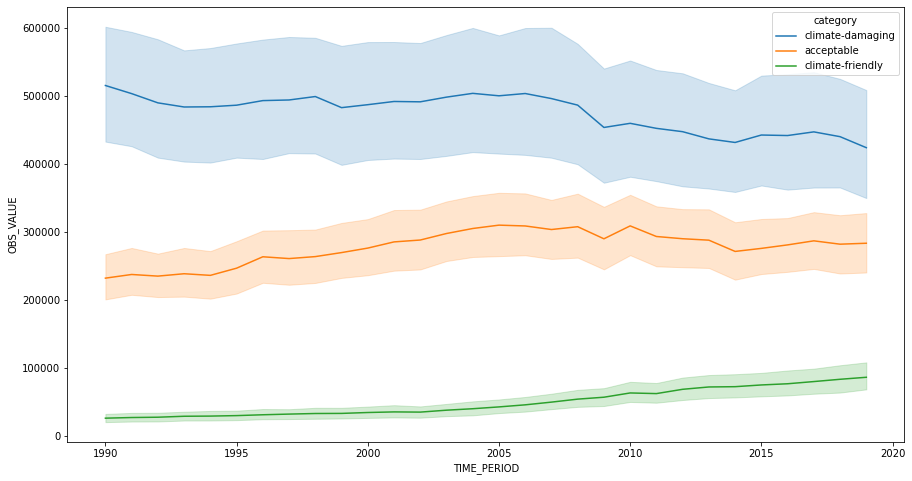

In [22]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(data=df_twh, x="TIME_PERIOD", y="OBS_VALUE", hue="category", estimator=sum)
plt.show()

The generalised picture gives us the trend we were hoping for. Climate-friendly energy goes up, acceptable energy plateaues, climate-damaging energy goes down. It all seems to be early days though.

We still need to check if the overall trend for each source category is predictable and if we can predict the trend for a few decades ahead. Let's first try it on the simplified dataset (which would exclude the usage variable and the geo variable) and then see if we can make it more interesting by adding geo dimension.

MODELING

Now that we have a good understanding of the data, let's attempt to predict the energy consumption. I have made multiple attempts making a Random Forest based accurate prediction, but it looks like the trend is not identifiable unless looked at across the entire span of 30 years. Therefore the RF model tends to overfit but fails to capture the trend in future years (I'll submit a separate extract). I decided to go with a simpler model which would not overfit but would reproduce the trend and allow making an assumption until 2050.

In [23]:
df_pred = df_twh.groupby(['TIME_PERIOD','category']).sum().reset_index()
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TIME_PERIOD  90 non-null     int64  
 1   category     90 non-null     object 
 2   OBS_VALUE    90 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


In [24]:
cat_list = df_pred['category'].unique()
cat_list

array(['acceptable', 'climate-damaging', 'climate-friendly'], dtype=object)

Accuracy on acceptable sources:  0.861
Accuracy on climate-damaging sources:  0.781
Accuracy on climate-friendly sources:  0.991


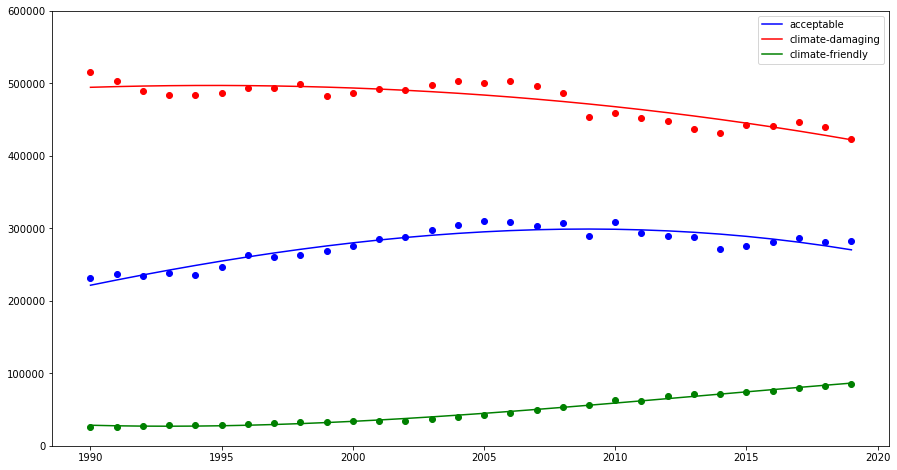

In [25]:
# use polynomial features on linear regression to produce trend lines on historical data

df_pred_acc = df_pred[df_pred.loc[:, ('category')] == cat_list[0]]
X_lr = df_pred_acc.iloc[:, 0].values.reshape(-1, 1)
Y_lr_acc = df_pred_acc.iloc[:, 2].values.reshape(-1, 1)

df_pred_dam = df_pred[df_pred.loc[:, ('category')] == cat_list[1]]
Y_lr_dam = df_pred_dam.iloc[:, 2].values.reshape(-1, 1)

df_pred_fr = df_pred[df_pred.loc[:, ('category')] == cat_list[2]]
Y_lr_fr = df_pred_fr.iloc[:, 2].values.reshape(-1, 1)   

degree = 3
lr_regressor_acc = make_pipeline(PolynomialFeatures(degree),LinearRegression())
lr_regressor_dam = make_pipeline(PolynomialFeatures(degree),LinearRegression())
lr_regressor_fr = make_pipeline(PolynomialFeatures(degree),LinearRegression())
model_acc = lr_regressor_acc.fit(X_lr, Y_lr_acc)
model_dam = lr_regressor_dam.fit(X_lr, Y_lr_dam)
model_fr = lr_regressor_fr.fit(X_lr, Y_lr_fr)

Y_lr_pred_acc = model_acc.predict(X_lr)
Y_lr_pred_dam = model_dam.predict(X_lr)
Y_lr_pred_fr = model_fr.predict(X_lr)

print("Accuracy on acceptable sources: ",np.around(r2_score(Y_lr_acc, Y_lr_pred_acc),decimals=3))
print("Accuracy on climate-damaging sources: ",np.around(r2_score(Y_lr_dam, Y_lr_pred_dam),decimals=3))
print("Accuracy on climate-friendly sources: ",np.around(r2_score(Y_lr_fr, Y_lr_pred_fr),decimals=3))

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.scatter(X_lr, Y_lr_acc, color='blue')
plt.scatter(X_lr, Y_lr_dam, color='red')
plt.scatter(X_lr, Y_lr_fr, color='green')
ax.plot(X_lr, Y_lr_pred_acc, color='blue', label='acceptable')
ax.plot(X_lr, Y_lr_pred_dam, color='red', label='climate-damaging')
ax.plot(X_lr, Y_lr_pred_fr, color='green', label='climate-friendly')
ax.legend()
ax.set_ylim([0, 600000])
plt.show()

I tried higher degrees, but r2 score stalls at 3, so I am going to keep it at 3 for now. 

Let's generate and plot new data

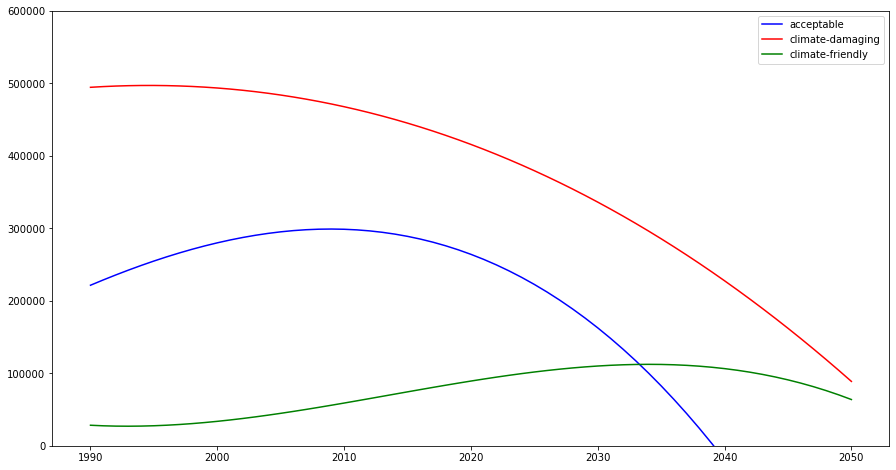

In [26]:
for i in range (0,31):
    X_lr_new = max(X_lr)+1
    X_lr_new = X_lr_new.reshape(-1, 1)
    X_lr = np.concatenate((X_lr, X_lr_new))
    
Y_lr_pred_acc = model_acc.predict(X_lr)
Y_lr_pred_dam = model_dam.predict(X_lr)
Y_lr_pred_fr = model_fr.predict(X_lr)

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
ax.plot(X_lr, Y_lr_pred_acc, color='blue', label='acceptable')
ax.plot(X_lr, Y_lr_pred_dam, color='red', label='climate-damaging')
ax.plot(X_lr, Y_lr_pred_fr, color='green', label='climate-friendly')
ax.legend()
ax.set_ylim([0, 600000])
plt.show()

EVALUATION

Right, the source usage seems to decline for all categories if we use a curve with high accuracy fit. However, I have a feeling that if we lower the bias a bit, the prediction might be better. In the end these sources are unlikely to reach zero mark, especially not the climate-friendly one, which has a clear upward trend. I'll write a full function with degree as input variable.

In [27]:
def predict_usage(data, degree_a, degree_b, degree_c):
    
    '''
    INPUT
    data - input dataset
    degree_a - polynomial features degree on acceptable sources
    degree_b - polynomial features degree on climate-damaging sources
    degree_c - polynomial features degree on climate-friendly sources
    
    OUTPUT
    
    X_lr - year timeline 1990-2050
    Y_lr_pred_a - prediction usage on acceptable sources
    Y_lr_pred_b - prediction usage on acceptable sources
    Y_lr_pred_c - prediction usage on acceptable sources
    
    '''
    
     
    #list unique values in category
    cat_list = df_pred['category'].unique()
    a = cat_list[0]
    b = cat_list[1]
    c = cat_list[2]
    
    #create a dataset per category
    data_a = data[data.loc[:, ('category')] == a]
    X_lr = data_a.loc[:, ('TIME_PERIOD')].values.reshape(-1, 1)
    Y_lr_a = data_a.loc[:, ('OBS_VALUE')].values.reshape(-1, 1)

    data_b = data[data.loc[:, ('category')] == b]
    Y_lr_b = data_b.loc[:, ('OBS_VALUE')].values.reshape(-1, 1)

    data_c = data[data.loc[:, ('category')] == c]
    Y_lr_c = data_c.loc[:, ('OBS_VALUE')].values.reshape(-1, 1)   

    #build models per category with corresponding degree
    lr_regressor_a = make_pipeline(PolynomialFeatures(degree_a),LinearRegression())
    lr_regressor_b = make_pipeline(PolynomialFeatures(degree_b),LinearRegression())
    lr_regressor_c = make_pipeline(PolynomialFeatures(degree_c),LinearRegression())
    model_a = lr_regressor_a.fit(X_lr, Y_lr_a)
    model_b = lr_regressor_b.fit(X_lr, Y_lr_b)
    model_c = lr_regressor_c.fit(X_lr, Y_lr_c)

    #predict values
    Y_lr_pred_a = model_a.predict(X_lr)
    Y_lr_pred_b = model_b.predict(X_lr)
    Y_lr_pred_c = model_c.predict(X_lr)

    #check r2 score
    print("Accuracy on acceptable sources: ",np.around(r2_score(Y_lr_a, Y_lr_pred_a),decimals=3))
    print("Accuracy on climate-damaging sources: ",np.around(r2_score(Y_lr_b, Y_lr_pred_b),decimals=3))
    print("Accuracy on climate-friendly sources: ",np.around(r2_score(Y_lr_c, Y_lr_pred_c),decimals=3))

    #add new rows for year
    for i in range (0,31):
        X_lr_new = max(X_lr)+1
        X_lr_new = X_lr_new.reshape(-1, 1)
        X_lr = np.concatenate((X_lr, X_lr_new))

    #predict values on new data    
    Y_lr_pred_a = model_a.predict(X_lr)
    Y_lr_pred_b = model_b.predict(X_lr)
    Y_lr_pred_c = model_c.predict(X_lr)

    #plot all predicted trends
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(X_lr, Y_lr_pred_a, color='blue', label=a)
    ax.plot(X_lr, Y_lr_pred_b, color='red', label=b)
    ax.plot(X_lr, Y_lr_pred_c, color='green', label=c)
    ax.legend()
    ax.set_ylim([0, max(Y_lr_b)])
    plt.show()
    
    return X_lr, Y_lr_pred_a, Y_lr_pred_b, Y_lr_pred_c

Accuracy on acceptable sources:  0.859
Accuracy on climate-damaging sources:  0.781
Accuracy on climate-friendly sources:  0.987


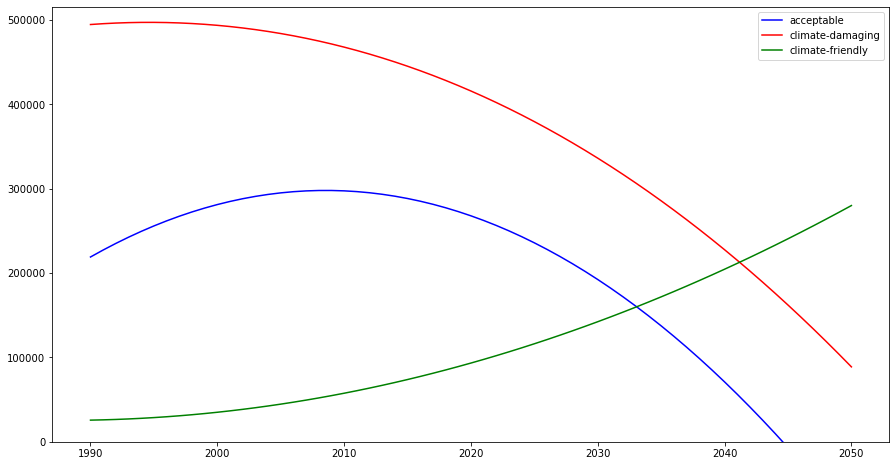

In [28]:
X_years, Y_acc, Y_dam, Y_fr = predict_usage(df_pred, 2, 3, 2)

I think this is good enough. It lowers a bit the accuracy on climate-friendly, just enough to capture the trend. More detailed prediction is hardly possible, as we saw in the Random Forests attempts (I'll submit an extract separately). Climate damaging is rather steep, so I'd go for higher accuracy there, with acceptable sources I'm still indecided, the historic data shows more of a plateau with a slight downward trend, however, degree 3 captures this trend perhaps too radically, I'd settle for degree 2 here, especially because we are after a more real life projection.

The resulting set of curves is looking rather optimistic too. I will write a small function to see in which year "green" sources prevail over others.

In [29]:
def green_energy_year(X_years, Y_acc, Y_dam, Y_fr):
        
    '''
    INPUT
    X_lr - year timeline 1990-2050
    Y_acc - prediction usage on acceptable sources
    Y_dam - prediction usage on climate-damaging sources
    Y_fr - prediction usage on climate-friendly sources
    
    OUTPUT
    prints closest year match between green and non-green energy sources usage, year of least usage of non-green energy sources
    
    '''
    
    df_pred_final = pd.DataFrame(data = {'Year': [ k for v in X_years.tolist() for k in v], 'Acceptable': [ k for v in Y_acc.tolist() for k in v], 
                                     'Damaging': [ k for v in Y_dam.tolist() for k in v], 'Friendly': [ k for v in Y_fr.tolist() for k in v]})
    df_pred_final['delta_acc'] = np.around(df_pred_final['Friendly'] - df_pred_final['Acceptable'], decimals=0)
    df_pred_final['delta_dam'] = np.around(df_pred_final['Friendly'] - df_pred_final['Damaging'], decimals=0)
    acc_win_over = df_pred_final[df_pred_final['delta_acc'] == min(df_pred_final['delta_acc'], key=abs)]['Year'].values[0]
    acc_zero = df_pred_final[df_pred_final['Acceptable'] == min(df_pred_final['Acceptable'], key=abs)]['Year'].values[0]
    dam_win_over = df_pred_final[df_pred_final['delta_dam'] == min(df_pred_final['delta_dam'], key=abs)]['Year'].values[0]
    dam_zero = df_pred_final[df_pred_final['Damaging'] == min(df_pred_final['Damaging'], key=abs)]['Year'].values[0]
    
    print("Year when climate-friendly energy sources come closest to acceptable energy sources in consumption: ", acc_win_over)
    print("Year when acceptable energy sources are least used: ", acc_zero)
    print("Year when climate-friendly energy sources come closest to climate-damaging energy sources in consumption: ", dam_win_over)
    print("Year when climate-damaging energy sources are least used: ", dam_zero)


In [30]:
green_energy_year(X_years, Y_acc, Y_dam, Y_fr)

Year when climate-friendly energy sources come closest to acceptable energy sources in consumption:  2033
Year when acceptable energy sources are least used:  2045
Year when climate-friendly energy sources come closest to climate-damaging energy sources in consumption:  2041
Year when climate-damaging energy sources are least used:  2050


DEPLOYMENT

Now I'd like to expand it back to geography. Then we can generate the same prediction for each location. First of all I will write a full function on what we've done so far.

In [31]:
def predict_usage_geo(data, geo, deg_a, deg_b, deg_c):
        
    '''
    INPUT
    data - input dataset
    degree_a - polynomial features degree on acceptable sources
    degree_b - polynomial features degree on climate-damaging sources
    degree_c - polynomial features degree on climate-friendly sources
    
    OUTPUT
    
    Prints location, accuracy (r2) scores, builds plots with predictions up to 2050, 
    prints closest year match between green and non-green energy sources usage, year of least usage of non-green energy sources
    
    '''
    
    data_geo = data[data['geo'] == geo]
    print("Location: ",geo)
    X, Y_a, Y_b, Y_c = predict_usage(data_geo, deg_a, deg_b, deg_c)
    green_energy_year(X, Y_a, Y_b, Y_c)

Now I'll prepare a dataset with geographies.

In [32]:
df_pred_geo = df_twh.groupby(['TIME_PERIOD','category','geo']).sum().reset_index()

In [33]:
df_pred_geo['geo'].unique()

array(['AL', 'AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EA19', 'EE', 'EL',
       'ES', 'EU27_2020', 'EU28', 'FI', 'FR', 'HR', 'HU', 'IE', 'IS',
       'IT', 'LT', 'LU', 'LV', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO',
       'RS', 'SE', 'SI', 'SK', 'TR', 'UA', 'UK', 'XK', 'ME', 'MD', 'GE',
       'BA'], dtype=object)

Location:  DE
Accuracy on acceptable sources:  0.784
Accuracy on climate-damaging sources:  0.939
Accuracy on climate-friendly sources:  0.968


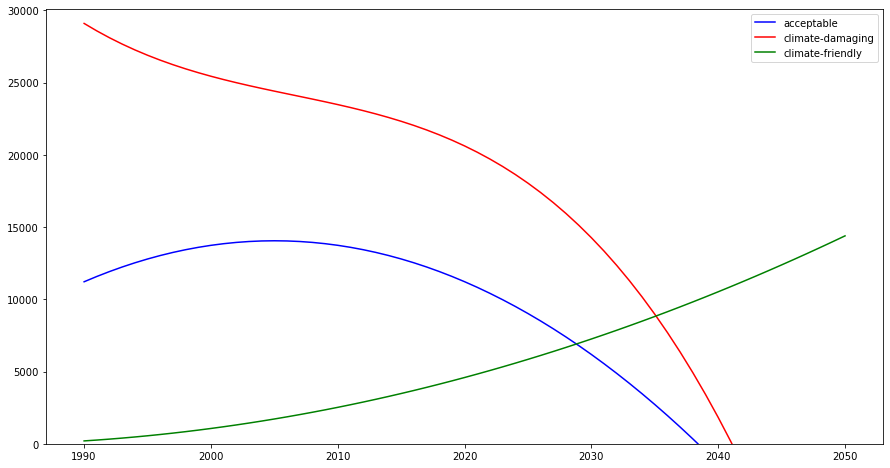

Year when climate-friendly energy sources come closest to acceptable energy sources in consumption:  2029
Year when acceptable energy sources are least used:  2038
Year when climate-friendly energy sources come closest to climate-damaging energy sources in consumption:  2035
Year when climate-damaging energy sources are least used:  2041


In [34]:
predict_usage_geo(df_pred_geo, 'DE', 2, 3, 2)

Location:  UK
Accuracy on acceptable sources:  0.76
Accuracy on climate-damaging sources:  0.982
Accuracy on climate-friendly sources:  0.985


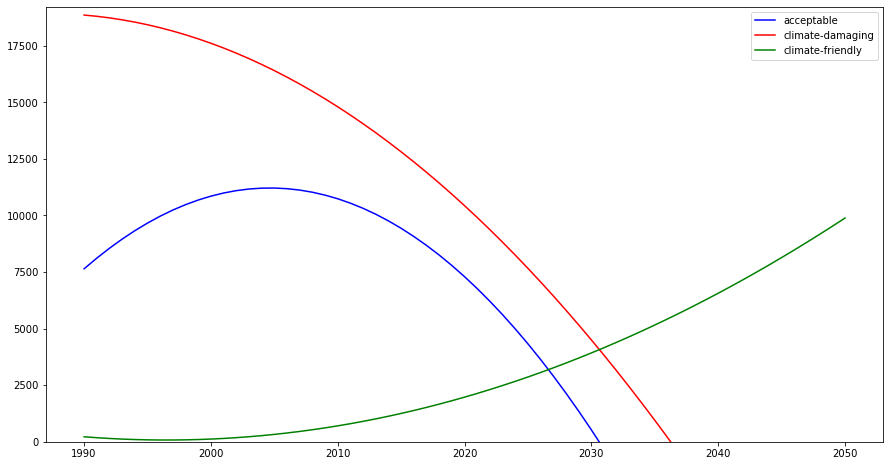

Year when climate-friendly energy sources come closest to acceptable energy sources in consumption:  2027
Year when acceptable energy sources are least used:  2031
Year when climate-friendly energy sources come closest to climate-damaging energy sources in consumption:  2031
Year when climate-damaging energy sources are least used:  2036


In [35]:
predict_usage_geo(df_pred_geo, 'UK', 2, 2, 2)

Location:  FR
Accuracy on acceptable sources:  0.952
Accuracy on climate-damaging sources:  0.899
Accuracy on climate-friendly sources:  0.93


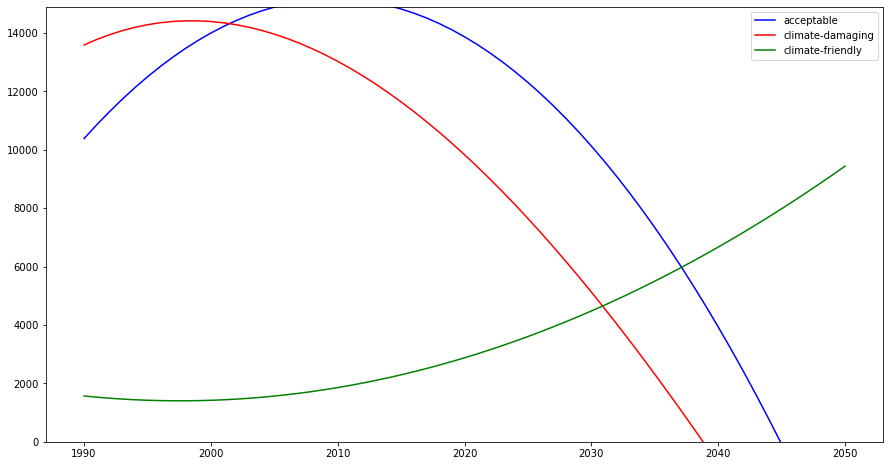

Year when climate-friendly energy sources come closest to acceptable energy sources in consumption:  2037
Year when acceptable energy sources are least used:  2045
Year when climate-friendly energy sources come closest to climate-damaging energy sources in consumption:  2031
Year when climate-damaging energy sources are least used:  2039


In [36]:
predict_usage_geo(df_pred_geo, 'FR', 2, 3, 2)

Location:  IT
Accuracy on acceptable sources:  0.845
Accuracy on climate-damaging sources:  0.902
Accuracy on climate-friendly sources:  0.972


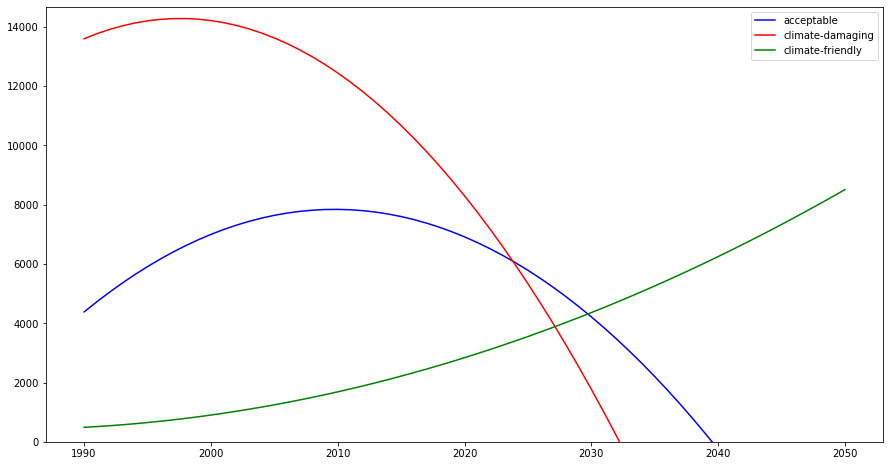

Year when climate-friendly energy sources come closest to acceptable energy sources in consumption:  2030
Year when acceptable energy sources are least used:  2040
Year when climate-friendly energy sources come closest to climate-damaging energy sources in consumption:  2027
Year when climate-damaging energy sources are least used:  2032


In [37]:
predict_usage_geo(df_pred_geo, 'IT', 2, 2, 2)

Location:  FI
Accuracy on acceptable sources:  0.913
Accuracy on climate-damaging sources:  0.609
Accuracy on climate-friendly sources:  0.966


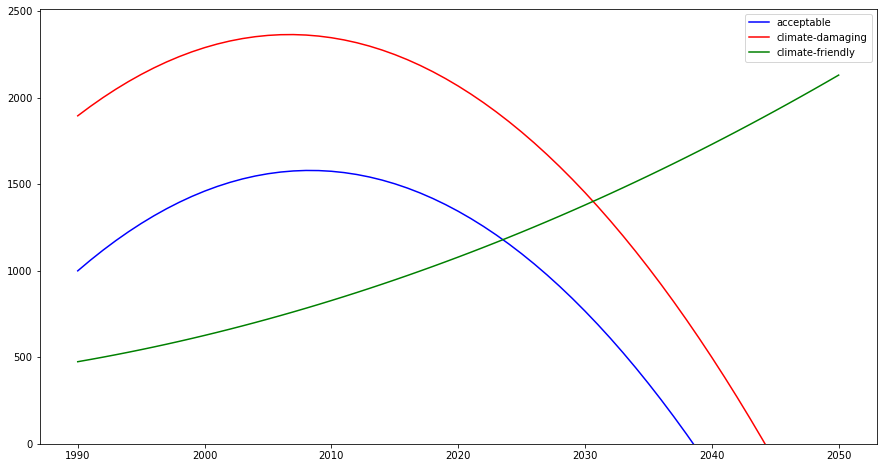

Year when climate-friendly energy sources come closest to acceptable energy sources in consumption:  2024
Year when acceptable energy sources are least used:  2039
Year when climate-friendly energy sources come closest to climate-damaging energy sources in consumption:  2031
Year when climate-damaging energy sources are least used:  2044


In [38]:
predict_usage_geo(df_pred_geo, 'FI', 2, 2, 2)

Location:  AL
Accuracy on acceptable sources:  0.812
Accuracy on climate-damaging sources:  0.316
Accuracy on climate-friendly sources:  0.317


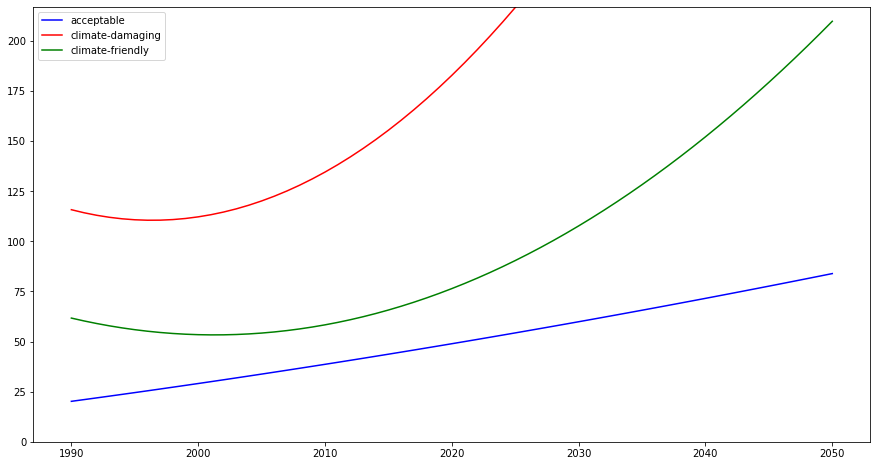

Year when climate-friendly energy sources come closest to acceptable energy sources in consumption:  2005
Year when acceptable energy sources are least used:  1990
Year when climate-friendly energy sources come closest to climate-damaging energy sources in consumption:  1990
Year when climate-damaging energy sources are least used:  1996


In [39]:
predict_usage_geo(df_pred_geo, 'AL', 2, 2, 2)

Many countries seem to be able to achieve the set goal. There are countries like Albania though, for example, which have a comparatively low consumption currently and an upward trend on all groups of sources (climate-damaging being most prominent). Others, like Finland, evidently invest into green energy and are closer to the goal than many others. Obviously, our study has a lot of limitations and assumptions: for example, we do not have access to the variables that determine the production of energy in various sources, e.g. a colder winter can have a significant upward impact, however, we will not be able to identify the reason. Also, the population grows, the consumption overall changes, so the observed trend in the overall energy source usage does not tell us anything about consumption per household, it may go up or down. Finally, we do not know what may or may not impact the trend in the future. Assuming everything stays in the same range, the forecast is quite optimistic. 